In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, SimpleRNN
from transformers import BertTokenizer, TFBertForSequenceClassification
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# Load text files from a folder
def load_text_files(folder_path):
    texts = []
    for file_name in os.listdir(folder_path):
        with open(os.path.join(folder_path, file_name), 'r', encoding='utf-8') as file:
            texts.append(file.read().strip())
    return texts

# Load train.csv and folders
train_df = pd.read_csv('train.csv', on_bad_lines='skip', quoting=3)
train_csv_texts = train_df['discourse_text'].dropna().tolist()
train_folder_texts = load_text_files('train')
test_folder_texts = load_text_files('test')

# Combine data
all_train_texts = train_csv_texts + train_folder_texts
all_test_texts = test_folder_texts

# Tokenize texts
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(all_train_texts)
train_sequences = tokenizer.texts_to_sequences(all_train_texts)
test_sequences = tokenizer.texts_to_sequences(all_test_texts)

# Pad sequences
max_length = 100
X_train = pad_sequences(train_sequences, maxlen=max_length, padding='post')
X_test = pad_sequences(test_sequences, maxlen=max_length, padding='post')
vocab_size = len(tokenizer.word_index) + 1

# Prepare target sequences
y_train = np.expand_dims(X_train[:, 1:], axis=-1)  # Target is input shifted by one
X_train = X_train[:, :-1]
y_test = np.expand_dims(X_test[:, 1:], axis=-1)
X_test = X_test[:, :-1]

In [4]:
# LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length - 1),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dense(vocab_size, activation='softmax')
])

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train LSTM
lstm_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate LSTM
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 264s 257ms/step - accuracy: 0.7744 - loss: 2.1634 - val_accuracy: 0.8177 - val_loss: 1.0794
Epoch 2/5
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 267s 264ms/step - accuracy: 0.8496 - loss: 0.8705 - val_accuracy: 0.9049 - val_loss: 0.5948
Epoch 3/5
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 266s 264ms/step - accuracy: 0.9276 - loss: 0.4427 - val_accuracy: 0.9484 - val_loss: 0.3377
Epoch 4/5
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 267s 265ms/step - accuracy: 0.9636 - loss: 0.2324 - val_accuracy: 0.9686 - val_loss: 0.2079
Epoch 5/5
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 311s 254ms/step - accuracy: 0.9807 - loss: 0.1271 - val_accuracy: 0.9802 - val_loss: 0.1359
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8384 - loss: 1.1047
LSTM Accuracy: 0.8384


In [5]:
  # RNN Model
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length - 1),
    SimpleRNN(128, return_sequences=True),
    Dense(vocab_size, activation='softmax')
])

rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train RNN
rnn_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate RNN
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test)
print(f"RNN Accuracy: {rnn_accuracy:.4f}")

Epoch 1/5
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 109s 102ms/step - accuracy: 0.7656 - loss: 2.5096 - val_accuracy: 0.7976 - val_loss: 1.2571
Epoch 2/5
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 133s 98ms/step - accuracy: 0.8037 - loss: 1.1838 - val_accuracy: 0.8138 - val_loss: 1.1306
Epoch 3/5
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 99s 98ms/step - accuracy: 0.8210 - loss: 1.0499 - val_accuracy: 0.8176 - val_loss: 1.0714
Epoch 4/5
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 144s 100ms/step - accuracy: 0.8277 - loss: 0.9793 - val_accuracy: 0.8202 - val_loss: 1.0447
Epoch 5/5
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 142s 100ms/step - accuracy: 0.8288 - loss: 0.9543 - val_accuracy: 0.8212 - val_loss: 1.0297
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1071 - loss: 5.7454
RNN Accuracy: 0.1071


In [7]:
# Function to augment input sentence
def augment_sentence(input_sentence, model, tokenizer, max_length):
    input_sequence = tokenizer.texts_to_sequences([input_sentence])
    input_sequence = pad_sequences(input_sequence, maxlen=max_length - 1, padding='post')

    # Generate predictions
    predictions = model.predict(input_sequence, verbose=0)
    predicted_sequence = np.argmax(predictions, axis=-1)[0]

    # Convert back to words
    augmented_sentence = ' '.join([tokenizer.index_word.get(idx, '') for idx in predicted_sequence if idx != 0])
    return augmented_sentence

# Example usage
input_sentence = input("Enter a sentence: ")
print("Augmented with LSTM:", augment_sentence(input_sentence, lstm_model, tokenizer, max_length))
print("Augmented with RNN:", augment_sentence(input_sentence, rnn_model, tokenizer, max_length))

Enter a sentence: I love playing soccer in the park with my friends.
Augmented with LSTM: love playing soccer in the classroom with my friends
Augmented with RNN: think to sports school school a friends


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
LSTM BLEU Score: 0.5848765580596493
RNN BLEU Score: 3.4573743523446733e-155


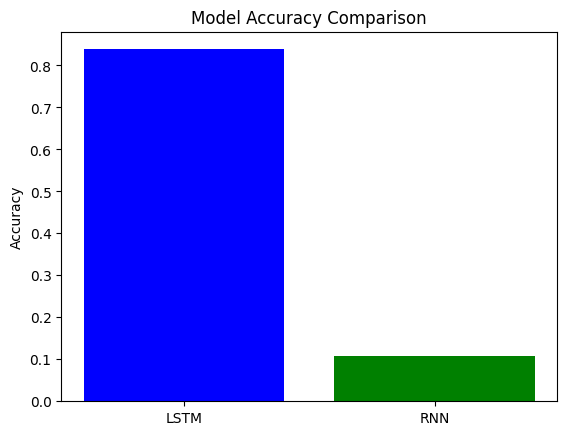

In [9]:
# Helper for BLEU Score
def calculate_bleu(reference, candidate):
    return sentence_bleu([reference], candidate)

# BLEU Scores
lstm_bleu = calculate_bleu(X_test[0], np.argmax(lstm_model.predict(X_test[:1]), axis=-1)[0])
rnn_bleu = calculate_bleu(X_test[0], np.argmax(rnn_model.predict(X_test[:1]), axis=-1)[0])

# Metrics
print(f"LSTM BLEU Score: {lstm_bleu}")
print(f"RNN BLEU Score: {rnn_bleu}")

# Plot Metrics
models = ['LSTM', 'RNN']
accuracies = [lstm_accuracy, rnn_accuracy]
plt.bar(models, accuracies, color=['blue', 'green'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()